In [4]:
%cd ~/REVIVAL2

/disk2/fli/REVIVAL2


In [8]:
import numpy as np
from Bio.PDB import PDBParser
from scipy.spatial import ConvexHull, Delaunay

def parse_active_site_coordinates(pdb_file, chain_id, residue_ids):
    """
    Extracts atomic coordinates for specified active site residues in a given chain.

    Args:
        pdb_file (str): Path to the PDB file.
        chain_id (str): Chain identifier (e.g., "A").
        residue_ids (list): List of residue IDs (e.g., [123, 124, 125]).

    Returns:
        np.ndarray: Array of atomic coordinates for the active site.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("enzyme", pdb_file)
    coords = []

    # Iterate over chains to find the matching chain
    for chain in structure.get_chains():
        if chain.id == chain_id:
            # Iterate over residues in the chain
            for res in chain.get_residues():
                if res.id[1] in residue_ids:
                    # Collect atomic coordinates for the residue
                    for atom in res.get_atoms():
                        coords.append(atom.coord)
    
    return np.array(coords)


def compute_convex_hull_volume(coords):
    """Compute the volume of a convex hull for the active site."""
    hull = ConvexHull(coords)
    return hull.volume

def compute_alpha_shape_volume(coords, alpha=1.5):
    """Compute the volume of an alpha shape (approximation of the pocket)."""
    tri = Delaunay(coords)
    tetrahedra = coords[tri.simplices]
    volumes = []
    for tetra in tetrahedra:
        vol = np.abs(np.linalg.det(np.c_[tetra - tetra[0], [1, 1, 1, 1]]) / 6.0)
        if vol <= alpha:
            volumes.append(vol)
    return sum(volumes)

In [5]:
from REVIVAL.zs.plip import get_plip_active_site_dict

/disk2/fli/miniconda3/envs/REVIVAL_ligmpnn/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [10]:



# Input PDB and active site residues
enzyme_pdb = "/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/ParLQ/F89A_0/F89A_0.pdb"  # Replace with your enzyme PDB file

chain_id = "A"  # Specify the chain of interest
residue_ids = list(get_plip_active_site_dict("/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/ParLQ/F89A_0/report.xml").keys())  # Specify the active site residue IDs

# Parse coordinates for active site residues
active_site_coords = parse_active_site_coordinates(enzyme_pdb, chain_id, residue_ids)

# Compute volumes (reuse previous volume functions)
convex_hull_volume = compute_convex_hull_volume(active_site_coords)
alpha_shape_volume = compute_alpha_shape_volume(active_site_coords)

# Output results
print(f"Active Site Volume (Convex Hull): {convex_hull_volume:.2f} Å³")
print(f"Active Site Volume (Alpha Shape): {alpha_shape_volume:.2f} Å³")



Active Site Volume (Convex Hull): 12512.56 Å³
Active Site Volume (Alpha Shape): 1378.41 Å³


In [10]:
def calculate_pocket_volume(pdb_file, chain_id, resid_list):
    """
    Calculate the active site solvent-accessible surface area (SASA) using PyMOL.

    Args:
        pdb_file (str): Path to the PDB file.
        chain_id (str): Chain ID to specify the protein chain (e.g., "A").
        resid_list (list): List of residue IDs (e.g., [123, 124, 125]).

    Returns:
        float: Solvent-accessible surface area (SASA) of the active site in Å².
    """
    import pymol2

    # Construct the selection string dynamically
    selection = " or ".join([f"(chain {chain_id} and resi {resid})" for resid in resid_list])

    with pymol2.PyMOL() as pymol:
        pymol.cmd.load(pdb_file, "enzyme")
        pymol.cmd.select("pocket", selection)
        pymol.cmd.set("dot_solvent", 1)  # Enable solvent-accessible surface calculation
        pymol.cmd.set("dot_density", 4)  # Increase dot density for better accuracy
        area = pymol.cmd.cavity_volume("pocket")  # Get the SASA for the selection
        return area

In [11]:
# Input PDB and active site residues
enzyme_pdb = "/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/ParLQ/F89A_0/F89A_0.pdb"  # Replace with your enzyme PDB file

chain_id = "A"  # Specify the chain of interest
resid_list = list(get_plip_active_site_dict("/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/ParLQ/F89A_0/report.xml").keys())  # Specify the active site residue IDs
calculate_pocket_volume(enzyme_pdb, chain_id, resid_list)

2553.607421875

In [3]:
import numpy as np
from Bio.PDB import PDBParser
from scipy.spatial import ConvexHull

def parse_furthest_atoms_from_calpha(pdb_file, chain_id, residue_ids):
    """
    Extracts the coordinates of the atom furthest from the Cα atom for each residue.

    Args:
        pdb_file (str): Path to the PDB file.
        chain_id (str): Chain identifier (e.g., "A").
        residue_ids (list): List of residue IDs (e.g., [123, 124, 125]).

    Returns:
        np.ndarray: Array of coordinates of the furthest atoms.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("enzyme", pdb_file)
    coords = []

    for chain in structure.get_chains():
        if chain.id == chain_id:
            for residue in chain.get_residues():
                if residue.id[1] in residue_ids:
                    # Find the Cα atom
                    calpha = None
                    for atom in residue.get_atoms():
                        if atom.get_id() == "CA":
                            calpha = atom.coord
                            break

                    if calpha is None:
                        continue  # Skip residues without a Cα atom

                    # Find the atom furthest from the Cα
                    max_distance = 0
                    furthest_atom = None
                    for atom in residue.get_atoms():
                        distance = np.linalg.norm(atom.coord - calpha)
                        if distance > max_distance:
                            max_distance = distance
                            furthest_atom = atom.coord

                    if furthest_atom is not None:
                        coords.append(furthest_atom)

    return np.array(coords)


def compute_convex_hull_volume(coords):
    """
    Compute the volume of a convex hull for the active site.

    Args:
        coords (np.ndarray): Array of atomic coordinates.

    Returns:
        float: Convex hull volume in Å³.
    """
    hull = ConvexHull(coords)
    return hull.volume


In [7]:
enzyme_pdb = "/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/ParLQ/F89A_0/F89A_0.pdb"  # Replace with your enzyme PDB file

chain_id = "A"  # Specify the chain of interest
residue_ids = list(get_plip_active_site_dict("/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/ParLQ/F89A_0/report.xml").keys())  # Specify the active site residue IDs
compute_convex_hull_volume(parse_furthest_atoms_from_calpha(enzyme_pdb, chain_id, residue_ids))

10682.038628352771

In [11]:
from REVIVAL.util import get_protein_structure

In [12]:
from Bio.PDB import MMCIFParser
from scipy.spatial import ConvexHull
import numpy as np

def extract_chains_and_calculate_volume(struct_file, chain_ids):
    """
    Extract specified chains from a PDB or CIF file and calculate their convex hull volume.

    Args:
        struct_file (str): Path to the PDB or CIF file.
        chain_ids (list): List of chain IDs to include (e.g., ['B', 'C']).

    Returns:
        float: Convex hull volume of the selected chains in Å³.
    """
    # Parse the structure file
    structure = get_protein_structure(struct_file)

    # Extract atomic coordinates for the specified chains
    coords = []
    for model in structure:
        for chain in model:
            if chain.id in chain_ids:
                for residue in chain:
                    for atom in residue:
                        coords.append(atom.coord)

    # Ensure we have enough points to calculate the convex hull
    coords = np.array(coords)
    if len(coords) < 4:
        raise ValueError("Not enough atoms to calculate a convex hull.")

    # Calculate the convex hull volume
    hull = ConvexHull(coords)
    return hull.volume

In [13]:
extract_chains_and_calculate_volume(enzyme_pdb, ["B"])

596.9947008011723

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize_coordinates(coords, title="3D Coordinate Visualization"):
    """
    Visualize a set of 3D coordinates as a scatter plot.

    Args:
        coords (np.ndarray): Nx3 array of 3D coordinates.
        title (str): Title of the plot.
    """
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    
    # Scatter plot the coordinates
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c="blue", marker="o", s=20, label="Points")
    
    # Add labels and legend
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_title(title)
    ax.legend()

    # Show the plot
    plt.show()


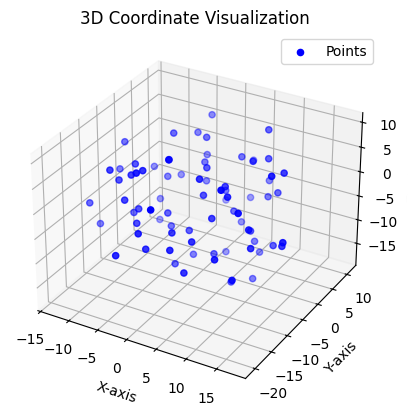

In [16]:
visualize_coordinates(parse_furthest_atoms_from_calpha(enzyme_pdb, chain_id, residue_ids))

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def extract_innermost_points(coords, threshold_factor=0.5):
    """
    Extract the innermost points based on distance from the centroid.

    Args:
        coords (np.ndarray): Nx3 array of 3D coordinates.
        threshold_factor (float): Fraction of the maximum distance to include points.

    Returns:
        np.ndarray: Innermost points within the defined threshold.
    """
    # Calculate the centroid
    centroid = np.mean(coords, axis=0)
    
    # Calculate distances from the centroid
    distances = np.linalg.norm(coords - centroid, axis=1)
    
    # Define the threshold distance
    max_distance = np.max(distances)
    threshold_distance = threshold_factor * max_distance
    
    # Extract points within the threshold
    innermost_points = coords[distances <= threshold_distance]
    
    return innermost_points, centroid

In [26]:

def parse_active_site_coordinates(pdb_file, chain_id, residue_ids):
    """
    Extracts atomic coordinates for specified active site residues in a given chain.

    Args:
        pdb_file (str): Path to the PDB file.
        chain_id (str): Chain identifier (e.g., "A").
        residue_ids (list): List of residue IDs (e.g., [123, 124, 125]).

    Returns:
        np.ndarray: Array of atomic coordinates for the active site.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("enzyme", pdb_file)
    coords = []

    # Iterate over chains to find the matching chain
    for chain in structure.get_chains():
        if chain.id == chain_id:
            # Iterate over residues in the chain
            for res in chain.get_residues():
                if res.id[1] in residue_ids:
                    # Collect atomic coordinates for the residue
                    for atom in res.get_atoms():
                        coords.append(atom.coord)
    
    return np.array(coords)


def calculate_innermost_points_by_direction(coords):
    """
    Calculate the innermost points based on the shortest distance in each proximate direction.

    Args:
        coords (np.ndarray): Nx3 array of 3D coordinates.

    Returns:
        np.ndarray: Innermost points in each direction.
        np.ndarray: The centroid of the points.
    """
    # Calculate the centroid
    centroid = np.mean(coords, axis=0)

    # Divide space into 6 directions relative to the centroid
    directions = {
        "+X": coords[coords[:, 0] >= centroid[0]],
        "-X": coords[coords[:, 0] < centroid[0]],
        "+Y": coords[coords[:, 1] >= centroid[1]],
        "-Y": coords[coords[:, 1] < centroid[1]],
        "+Z": coords[coords[:, 2] >= centroid[2]],
        "-Z": coords[coords[:, 2] < centroid[2]],
    }

    # Find the closest point to the centroid in each direction
    innermost_points = []
    for direction, points in directions.items():
        if len(points) > 0:
            # Calculate distances from the centroid
            distances = np.linalg.norm(points - centroid, axis=1)
            closest_point = points[np.argmin(distances)]
            innermost_points.append(closest_point)

    return np.array(innermost_points), centroid


def compute_convex_hull_volume(coords):
    """Compute the volume of a convex hull for the active site."""
    hull = ConvexHull(coords)
    return hull.volume

In [21]:
enzyme_pdb = "/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/ParLQ/F89A_0/F89A_0.pdb"  # Replace with your enzyme PDB file
chain_id = "A"  # Specify the chain of interest
residue_ids = list(get_plip_active_site_dict("/disk2/fli/REVIVAL2/zs/plip/af3/struct_joint/ParLQ/F89A_0/report.xml").keys())  # Specify the active site residue IDs


In [38]:
coords = parse_active_site_coordinates(enzyme_pdb, chain_id, residue_ids)

In [27]:
calculate_innermost_points_by_direction(coords)

(array([[ 2.841, -5.075, -0.116],
        [ 1.298, -6.636, -6.914],
        [ 2.855, -1.847,  2.893],
        [ 2.841, -5.075, -0.116],
        [ 2.841, -5.075, -0.116],
        [ 1.298, -6.636, -6.914]], dtype=float32),
 array([ 1.9636356, -4.5205655, -2.0851784], dtype=float32))

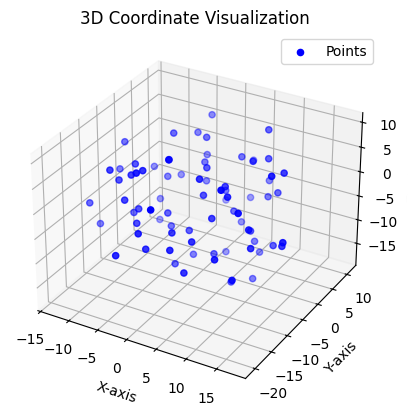

In [29]:
visualize_coordinates(parse_furthest_atoms_from_calpha(enzyme_pdb, chain_id, residue_ids))

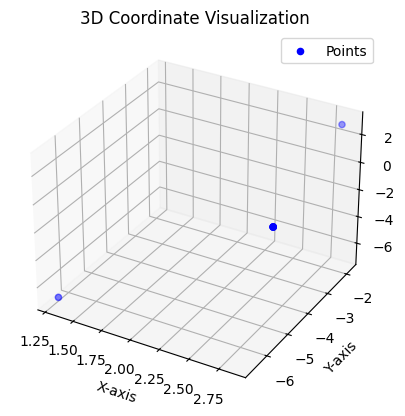

In [30]:

visualize_coordinates(calculate_innermost_points_by_direction(coords)[0])

In [39]:
innermost_points, centroid = extract_innermost_points(coords, threshold_factor=0.5)

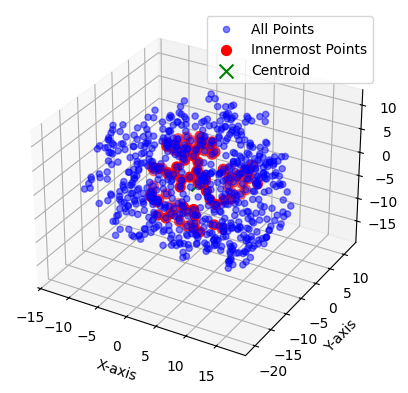

In [36]:
# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot all points
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c="blue", label="All Points", alpha=0.5)

# Plot innermost points
ax.scatter(innermost_points[:, 0], innermost_points[:, 1], innermost_points[:, 2],
           c="red", label="Innermost Points", s=50)

# Plot the centroid
ax.scatter(centroid[0], centroid[1], centroid[2], c="green", label="Centroid", s=100, marker="x")

# Labels and legend
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.legend()
plt.show()


In [40]:
import plotly.graph_objects as go
import numpy as np

# Create a scatter plot for all points
all_points = go.Scatter3d(
    x=coords[:, 0],
    y=coords[:, 1],
    z=coords[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.5),
    name='All Points'
)

# Create a scatter plot for innermost points
innermost_points_plot = go.Scatter3d(
    x=innermost_points[:, 0],
    y=innermost_points[:, 1],
    z=innermost_points[:, 2],
    mode='markers',
    marker=dict(size=8, color='red', opacity=0.8),
    name='Innermost Points'
)

# Create a scatter plot for the centroid
centroid_plot = go.Scatter3d(
    x=[centroid[0]],
    y=[centroid[1]],
    z=[centroid[2]],
    mode='markers',
    marker=dict(size=12, color='green', symbol='x'),
    name='Centroid'
)

# Combine all plots
fig = go.Figure(data=[all_points, innermost_points_plot, centroid_plot])

# Add axis labels
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
    ),
    title="Interactive 3D Visualization of Points",
)

# Show the interactive plot
fig.show()
